### Path Finder: What are the potential paths between two nodes?
### This pipeline can be used to get a ranked path between A and B given a set of paths.

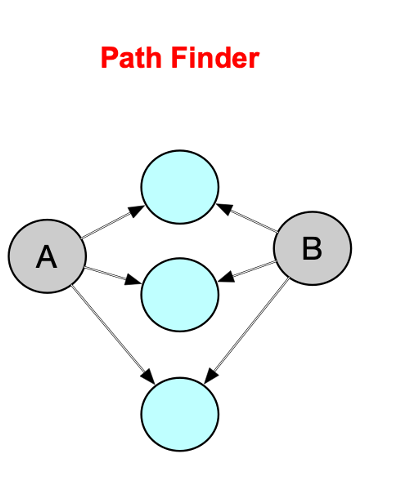

Example questions: 

What drugs may treat ovarian cancer (MONDO:0008170) patients with BRCA1 mutation?  

What is the mechanism of Olaparib being effective for patients with BRCA1 mutation?


In [1]:
#!pip install openai


In [1]:
# include path ../src in order to import modules
import sys
sys.path.append('../TCT')
import TCT as TCT
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets

In [ ]:
# Step1: List all the APIs in the translator system
Translator_KP_info,APInames= TCT.get_SmartAPI_Translator_KP_info()
#Translator_KP_info.to_csv('SmartAPI_Translator_KP_info.csv', index=False)
print(len(Translator_KP_info))

Skipping server without x-maturity: {'description': 'Production server', 'url': 'https://smart-api.info/api'}
Skipping server without x-maturity: {'description': 'Development server', 'url': 'https://dev.smart-api.info/api'}
SmartAPI API
Skipping server without production, staging or testing: {'description': 'Development server', 'url': 'https://dev.smart-api.info/api'}
Skipping server without x-maturity: {'description': 'Staging server', 'url': 'http://biothings.test.transltr.io/annotator'}
Skipping server without x-maturity: {'description': 'CI server', 'url': 'http://biothings.ci.transltr.io/annotator'}
98


In [3]:
# Step1: List all the APIs in the translator system
#APInames = TCT.list_Translator_APIs()
#print(APInames)
#print(APInames.keys())

# Step 2: Get metaKG and all predicates from Translator APIs
metaKG = TCT.get_KP_metadata(APInames) # This only applies to the Translator APIs
#print(metaKG.columns)
#print(metaKG.shape)

#metaKG.to_csv('../metaData/metaKG.csv', index=False)
#metaKG = pd.read_csv('../metaData/metaKG.csv')
All_predicates = list(set(metaKG['KG_category']))
All_categories = list((set(list(set(metaKG['Subject']))+list(set(metaKG['Object'])))))

In [3]:
#### The following use case is to fine the Genes or proteins that connect the gene BRCA2 and the drug Olaparib


In [4]:
# Step 3: set input parameters

# Node1 for query
input_node1 = 'BRCA2'
input_node1_id = TCT.get_curie(input_node1)
print(input_node1_id)
input_node1_list = [input_node1_id]
input_node1_category = ['biolink:Gene'] # Node: this has to be in a format of biolink:xxx

#Node2 for query
input_node2_list = []
#input_node2_category = ['biolink:Drug','biolink:SmallMolecule'] # Node: this has to be in a format of biolink:xxx
input_node2_category = ['biolink:Gene','biolink:Protein'] # Node: this has to be in a format of biolink:xxx


# Get all predicates for the input node1 and node2, user can furter select the predicates among this list
sele_predicates = list(set(TCT.select_concept(sub_list=input_node1_category,
                                              obj_list=input_node2_category,
                                              metaKG=metaKG)))

print("all relevant predicates in Translator:")
print(sele_predicates)
# select predicates

# Get all APIs for the input node1 and node2, user can furter select the APIs among this list
sele_APIs_1 = TCT.select_API(sub_list=input_node1_category,
                             obj_list=input_node2_category,
                             metaKG=metaKG)
print("all relevant APIs in Translator:")
print(sele_APIs_1)

# get API URLs
API_URLs_1 = TCT.get_Translator_API_URL(sele_APIs_1, APInames)

#---------------------------------------------------------------------------------------------------------------------------------#

# Node3 for query
#input_node3 = 'Ovarian cancer'
input_node3 = "Olaparib"
input_node3_id = TCT.get_curie(input_node3)
print(input_node3_id)
#input_node3_id = "MONDO:0008170" # have to change UMLS to MONDO ids
input_node3_list = [input_node3_id]
input_node3_category = ['biolink:SmallMolecule', 'biolink:Drug','biolink:ChemicalSubstance'] # Node: this has to be in a format of biolink:xxx
#input_node3_category = ['biolink:Disease']

# Get all predicates for the input node1 and node2, user can furter select the predicates among this list
sele_predicates_2 = list(set(TCT.select_concept(sub_list=input_node3_category,
                                                obj_list=input_node2_category,
                                                metaKG=metaKG)))
print("all relevant predicates in Translator:")
print(sele_predicates_2)
# select predicates

# Get all APIs for the input node1 and node2, user can furter select the APIs among this list
sele_APIs_2 = TCT.select_API(sub_list=input_node3_category,
                             obj_list=input_node2_category,
                             metaKG=metaKG)
print("all relevant APIs in Translator:")
print(sele_APIs_2)

# get API URLs
API_URLs_2 = TCT.get_Translator_API_URL(sele_APIs_2, 
                                      APInames)

NCBIGene:675
all relevant predicates in Translator:
['biolink:acts_upstream_of_or_within', 'biolink:chemically_similar_to', 'biolink:coexists_with', 'biolink:close_match', 'biolink:gene_product_of', 'biolink:produces', 'biolink:causes', 'biolink:produced_by', 'biolink:associated_with_increased_likelihood_of', 'biolink:negatively_correlated_with', 'biolink:affected_by', 'biolink:positively_correlated_with', 'biolink:has_participant', 'biolink:coexpressed_with', 'biolink:derives_into', 'biolink:correlated_with', 'biolink:regulated_by', 'biolink:homologous_to', 'biolink:has_input', 'biolink:genetically_associated_with', 'biolink:physically_interacts_with', 'biolink:affects', 'biolink:has_part', 'biolink:related_to', 'biolink:genetically_interacts_with', 'biolink:associated_with_resistance_to', 'biolink:directly_physically_interacts_with', 'biolink:increases_response_to', 'biolink:decreases_response_to', 'biolink:derives_from', 'biolink:has_gene_product', 'biolink:associated_with_sensitivi

In [5]:
# Step 4: Format query json
query_json = TCT.format_query_json(input_node1_list,  # a list of identifiers for input node1
                                   input_node2_list,  # it can be empty list if only want to query node1
                                   input_node1_category,  # a list of categories of input node1
                                   input_node2_category,  # a list of categories of input node2
                                   sele_predicates) # a list of predicates
# Step 5: Query Translator APIs and parse results
result = TCT.parallel_api_query(API_URLs_1,query_json=query_json, max_workers=len(API_URLs_1))
# Step 6: Parse results
result_parsed = TCT.parse_KG(result)
# Step 7: Ranking the results. This ranking method is based on the number of unique primary infores. It can only be used to rank the results with one defined node.
result_ranked_by_primary_infores = TCT.rank_by_primary_infores(result_parsed, input_node1_id)   # input_node1_id is the curie id of the input node, such as "NCBIGene:672"


Warning Code:404:https://api.pharmgkb.org/v1/query/
Warning Code:404:https://api-v3.monarchinitiative.org/query/
Warning Code:404:https://ia.transltr.io/api/v1.5/query/
Warning Code:404:https://spokekp.transltr.io/api/v1.5/query/
Warning Code:404:https://molepro-trapi.transltr.io/molepro/trapi/v1.5/query/
Warning Code:400:https://biothings.ncats.io/biggim_drugresponse_kp/query/
Warning Code:400:https://biothings.ncats.io/innatedb/query/
Warning Code:400:https://biothings.ncats.io/text_mining_targeted_association/query/
Warning Code:400:https://biothings.ncats.io/semmeddb/query/
Success!https://automat.transltr.io/monarch-kg/query/
Warning Code:400:https://biothings.ncats.io/annotator/query/
Success!https://automat.renci.org/ehr-may-treat-kp/query/
Success!https://automat.transltr.io/icees-kg/query/
Success!https://automat.transltr.io/cam-kp/query/
Warning Code:400:https://mygene.info/v3/query/
Success!https://automat.transltr.io/pharos/query/
Success!https://chp-api.transltr.io/query/S

UniProtKB:Q03468-1: no preferred name
UniProtKB:Q96GD0-1: no preferred name
ENSEMBL:ENSP00000499503: no preferred name
UniProtKB:Q03468-1: no preferred name
UniProtKB:P98175-5: no preferred name
ENSEMBL:ENSP00000499503: no preferred name
UniProtKB:P98175-5: no preferred name
UniProtKB:Q96GD0-1: no preferred name
[Text(0.5, 0, 'TP53'), Text(2.5, 0, 'BRCA1'), Text(4.5, 0, 'FANCD2'), Text(6.5, 0, 'PCNA'), Text(8.5, 0, 'BARD1'), Text(10.5, 0, 'XRCC3'), Text(12.5, 0, 'PARP1'), Text(14.5, 0, 'BCCIP'), Text(16.5, 0, 'DMC1'), Text(18.5, 0, 'ATM'), Text(20.5, 0, 'HMG20B'), Text(22.5, 0, 'RECQL5'), Text(24.5, 0, 'CDK2'), Text(26.5, 0, 'CHEK1'), Text(28.5, 0, 'HSP90AB1'), Text(30.5, 0, 'FANCG'), Text(32.5, 0, 'SYCP3'), Text(34.5, 0, 'RAD52'), Text(36.5, 0, 'USP11'), Text(38.5, 0, 'UBP11_HUMAN Ubiquitin carboxyl-terminal hydrolase 11 (sprot)'), Text(40.5, 0, 'RAD23A'), Text(42.5, 0, 'XPO1'), Text(44.5, 0, 'PALB2'), Text(46.5, 0, 'EMSY'), Text(48.5, 0, 'RAD51C')]


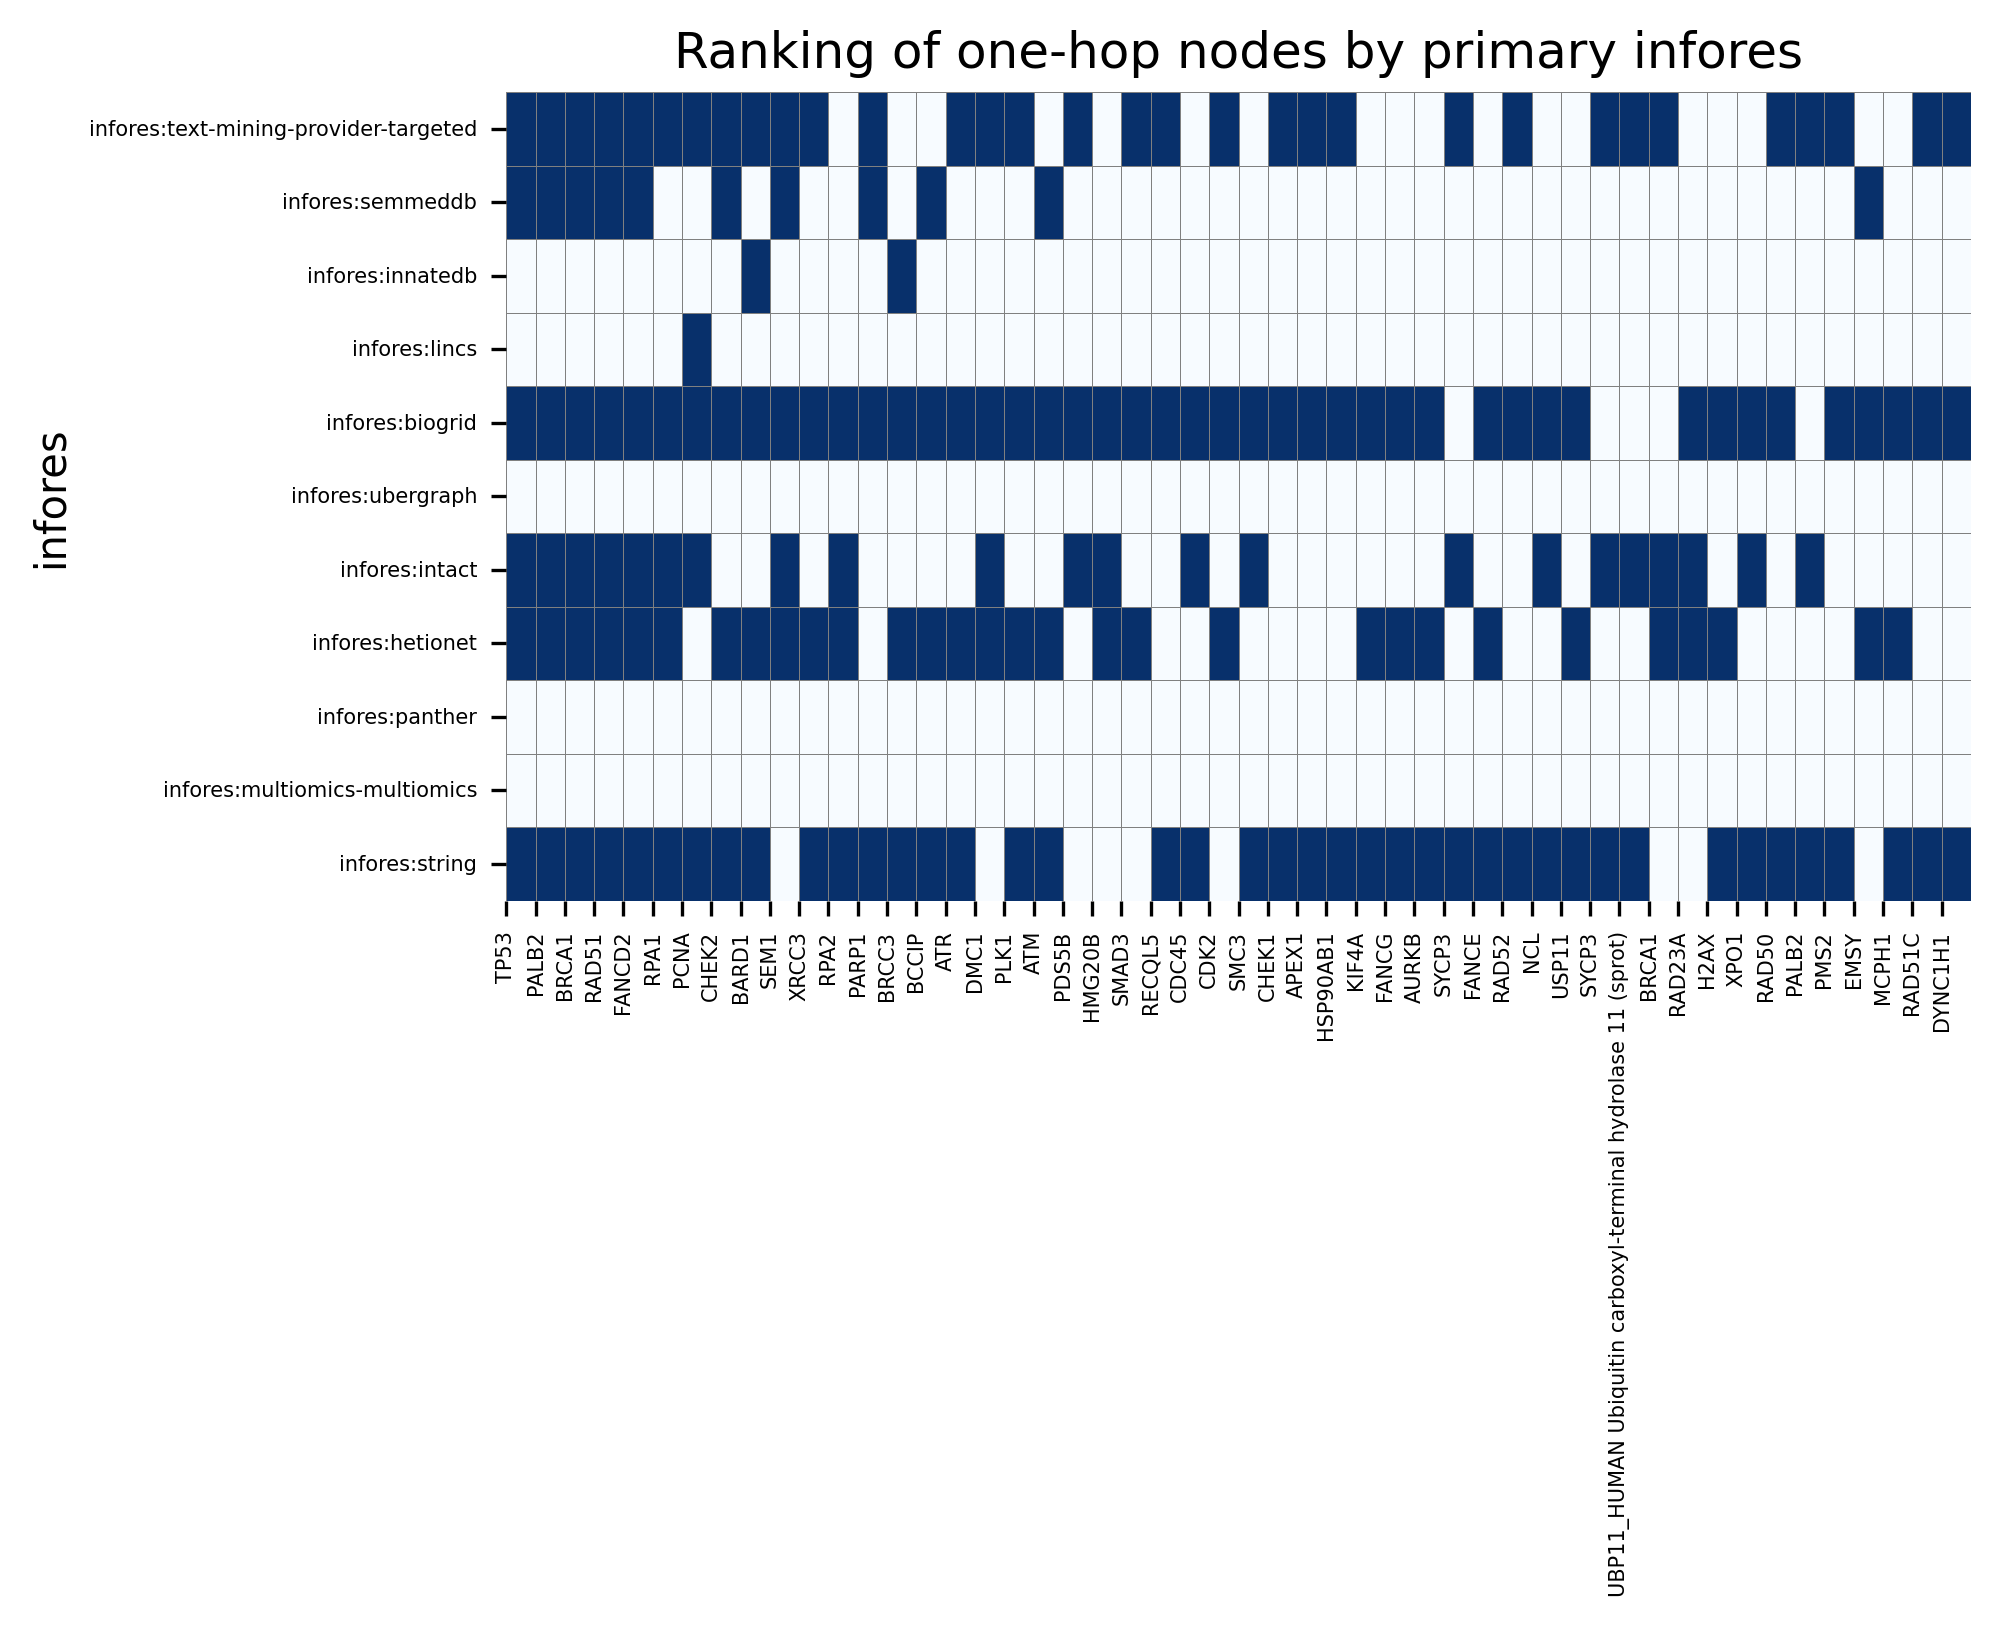

[Text(0.5, 0, 'TP53'), Text(2.5, 0, 'BRCA1'), Text(4.5, 0, 'FANCD2'), Text(6.5, 0, 'PCNA'), Text(8.5, 0, 'BARD1'), Text(10.5, 0, 'XRCC3'), Text(12.5, 0, 'PARP1'), Text(14.5, 0, 'BCCIP'), Text(16.5, 0, 'DMC1'), Text(18.5, 0, 'ATM'), Text(20.5, 0, 'HMG20B'), Text(22.5, 0, 'RECQL5'), Text(24.5, 0, 'CDK2'), Text(26.5, 0, 'CHEK1'), Text(28.5, 0, 'HSP90AB1'), Text(30.5, 0, 'FANCG'), Text(32.5, 0, 'SYCP3'), Text(34.5, 0, 'RAD52'), Text(36.5, 0, 'USP11'), Text(38.5, 0, 'UBP11_HUMAN Ubiquitin carboxyl-terminal hydrolase 11 (sprot)'), Text(40.5, 0, 'RAD23A'), Text(42.5, 0, 'XPO1'), Text(44.5, 0, 'PALB2'), Text(46.5, 0, 'EMSY'), Text(48.5, 0, 'RAD51C')]


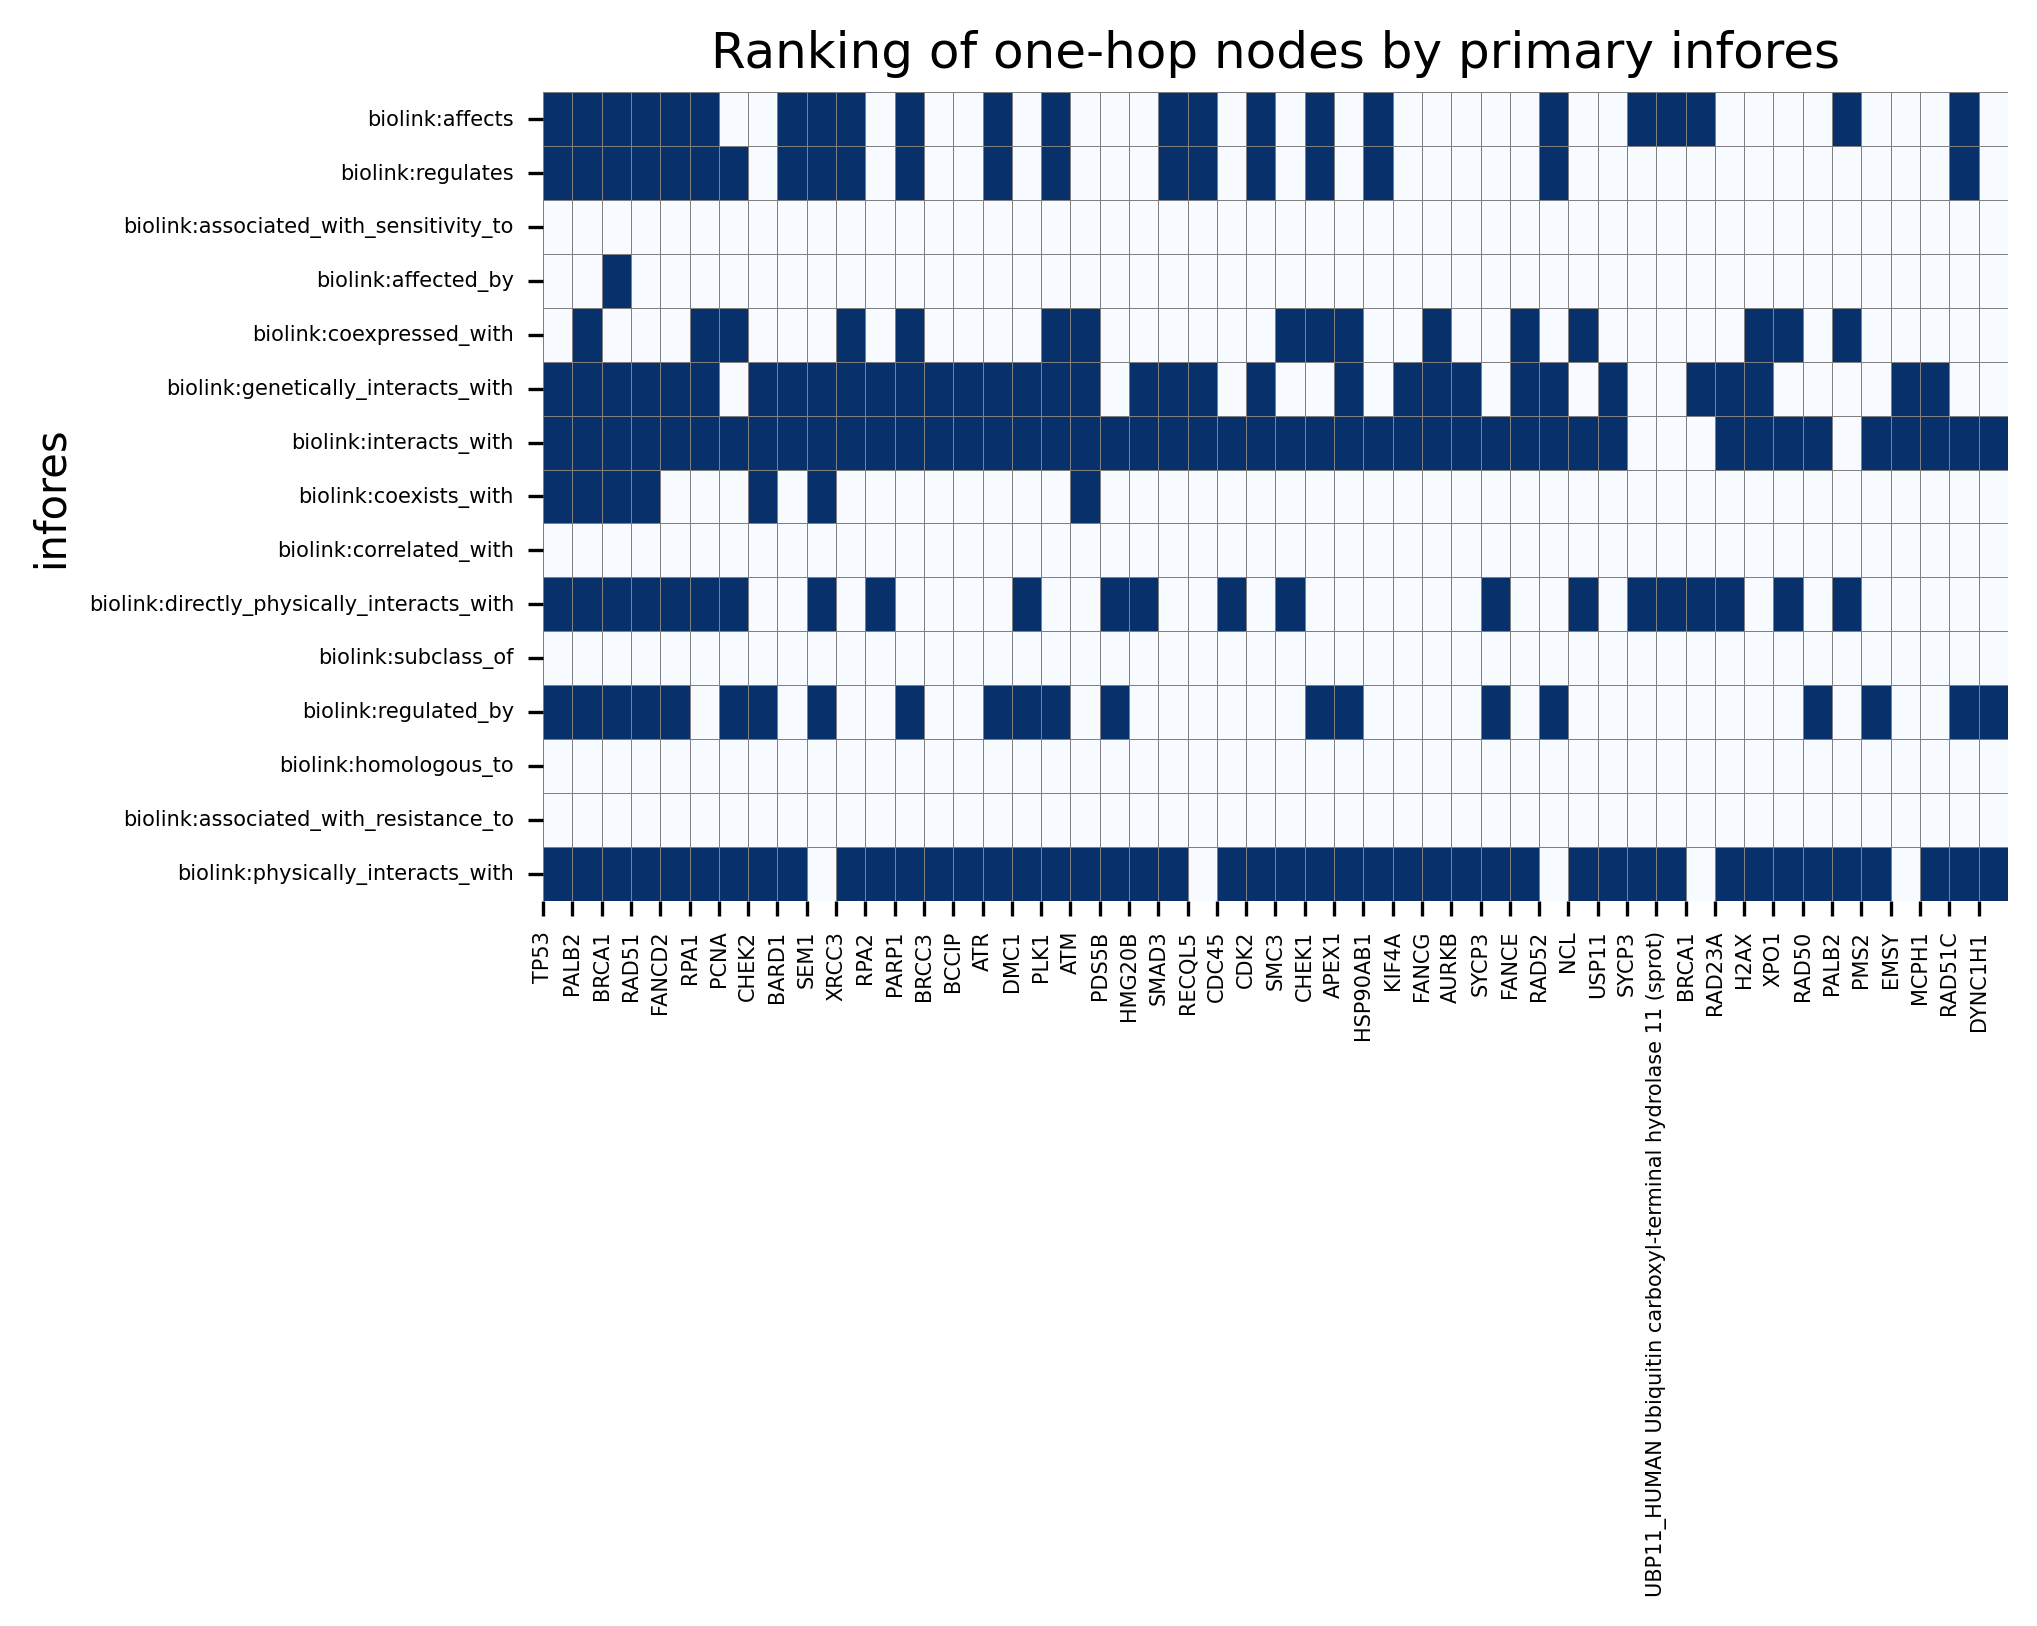

,TP53,PALB2,BRCA1,RAD51,FANCD2,RPA1,PCNA,CHEK2,BARD1,SEM1,...,RPA-related protein RADX isoform h1 (human),DNA damage-binding protein 2 isoform h1 (human),thymidylate synthase isoform h1 (human),ubiquitin carboxyl-terminal hydrolase 2 isoform h1 (human),DEP domain-containing protein 1A isoform h1 (human),heat shock factor 2-binding protein isoform h1 (human),USP26,coiled-coil domain-containing protein 18 isoform h1 (human),TACC3,MYBL2
biolink:affects,1,1,1,1,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
biolink:regulates,1,1,1,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
biolink:associated_with_sensitivity_to,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
biolink:affected_by,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
biolink:coexpressed_with,0,1,0,0,0,1,1,0,0,0,...,1,1,1,1,1,1,1,1,1,0
biolink:genetically_interacts_with,1,1,1,1,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
biolink:interacts_with,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
biolink:coexists_with,1,1,1,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
biolink:correlated_with,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
biolink:directly_physically_interacts_with,1,1,1,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Step 8: Visualize the results
TCT.visulization_one_hop_ranking(result_ranked_by_primary_infores, 
                                 result_parsed, 
                                 num_of_nodes = 50, 
                                 input_query = input_node1_id,
                                 fontsize = 5,
                                 title_fontsize=12)

In [9]:
# Step 9: Format query json
query_json2 = TCT.format_query_json(input_node3_list,  # a list of identifiers for input node1
                                   input_node2_list,  # it can be empty list if only want to query node1
                                   input_node3_category,  # a list of categories of input node1
                                   input_node2_category,  # a list of categories of input node2
                                   sele_predicates_2) # a list of predicates


In [10]:
# Step 10: Query Translator APIs and parse results
result2 = TCT.parallel_api_query(API_URLs_2,query_json=query_json2, max_workers=len(API_URLs_2))

# Step 11: Parse results
result_parsed2 = TCT.parse_KG(result2)

# Step 12: Ranking the results. This ranking method is based on the number of unique primary infores. It can only be used to rank the results with one defined node.
result_ranked_by_primary_infores2 = TCT.rank_by_primary_infores(result_parsed2, input_node3_id)   # input_node1_id is the curie id of the input node, such as "NCBIGene:672"


Warning Code:400:https://mychem.info/v1/query/
Warning Code:404:https://api.pharmgkb.org/v1/query/
Warning Code:404:https://molepro-trapi.transltr.io/molepro/trapi/v1.5/query/
Success!https://cooccurrence.ci.transltr.io/query/
Warning Code:400:https://biothings.ncats.io/multiomics_wellness_kp/query/
Success!https://automat.renci.org/ehr-clinical-connections-kp/query/
Warning Code:400:https://biothings.ncats.io/text_mining_targeted_association/query/
Warning Code:400:https://biothings.ncats.io/dgidb/query/
Warning Code:400:https://biothings.ncats.io/pfocr/query/
Warning Code:400:https://biothings.ncats.io/annotator/query/
Warning Code:400:https://biothings.ncats.io/bindingdb/query/
Warning Code:400:https://biothings.ncats.io/biggim_drugresponse_kp/query/
Warning Code:400:https://biothings.ncats.io/semmeddb/query/
Success!https://automat.renci.org/ehr-may-treat-kp/query/
Success!https://automat.transltr.io/hmdb/query/
Success!https://automat.transltr.io/ubergraph/query/
Warning Code:400:

NodeNorm does not know about these identifiers: TTD.TARGET:T17228,TTD.TARGET:T83059,TTD.TARGET:T34867,NCBIGene:NaN,NCBIGene:8205
[Text(0.5, 0, 'PARP1'), Text(2.5, 0, 'PARP3'), Text(4.5, 0, 'TNKS'), Text(6.5, 0, 'PARP15'), Text(8.5, 0, 'PARP10'), Text(10.5, 0, 'PARP12'), Text(12.5, 0, 'ATR'), Text(14.5, 0, 'ERBB2'), Text(16.5, 0, 'CHEK1'), Text(18.5, 0, 'TIPARP'), Text(20.5, 0, 'RAD51'), Text(22.5, 0, 'E2F8'), Text(24.5, 0, 'NBN'), Text(26.5, 0, 'MCL1'), Text(28.5, 0, 'ESR1')]


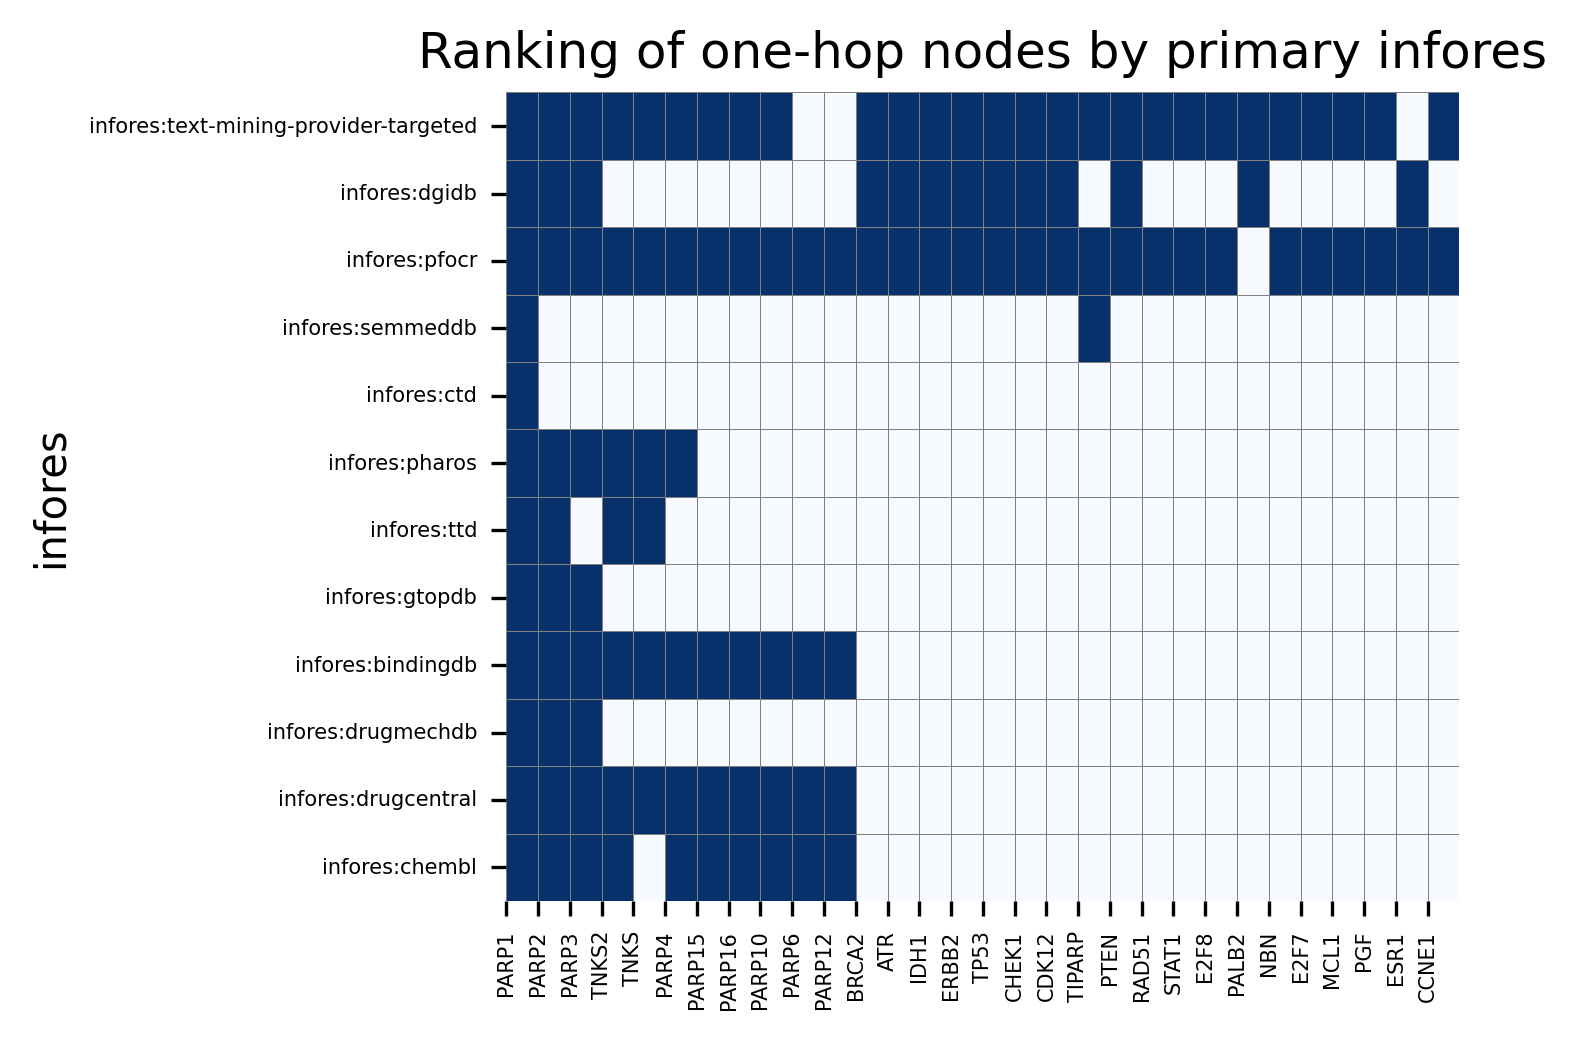

[Text(0.5, 0, 'PARP1'), Text(2.5, 0, 'PARP3'), Text(4.5, 0, 'TNKS'), Text(6.5, 0, 'PARP15'), Text(8.5, 0, 'PARP10'), Text(10.5, 0, 'PARP12'), Text(12.5, 0, 'ATR'), Text(14.5, 0, 'ERBB2'), Text(16.5, 0, 'CHEK1'), Text(18.5, 0, 'TIPARP'), Text(20.5, 0, 'RAD51'), Text(22.5, 0, 'E2F8'), Text(24.5, 0, 'NBN'), Text(26.5, 0, 'MCL1'), Text(28.5, 0, 'ESR1')]


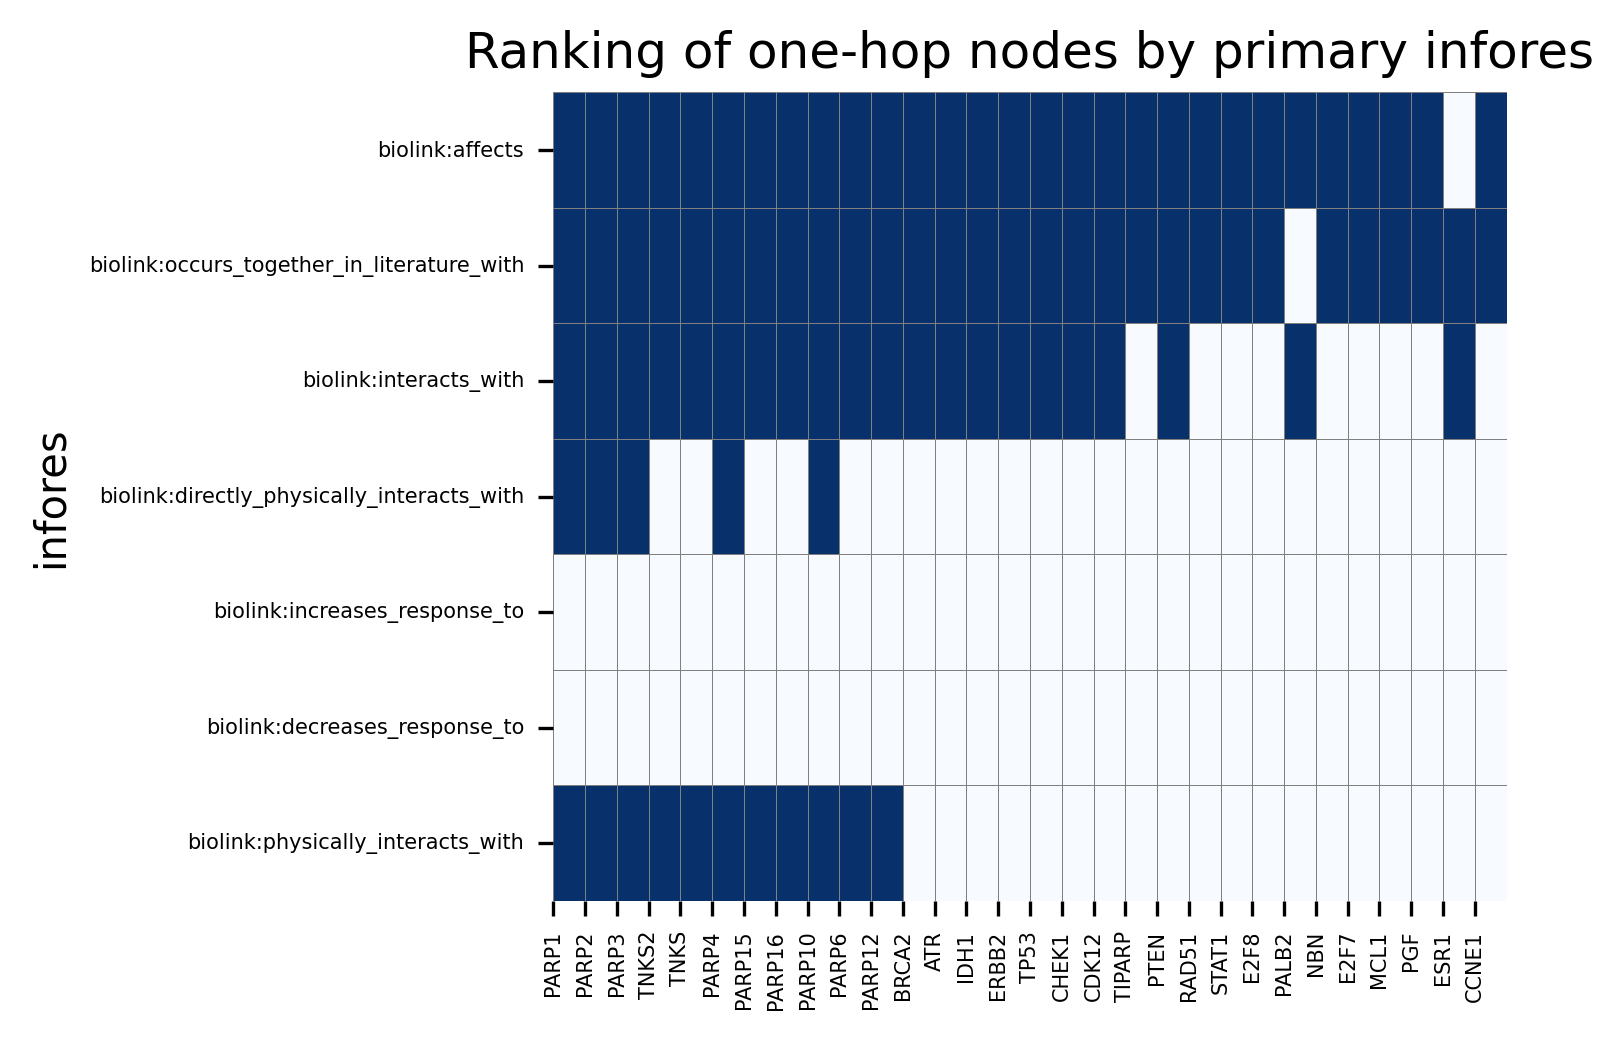

,PARP1,PARP2,PARP3,TNKS2,TNKS,PARP4,PARP15,PARP16,PARP10,PARP6,...,AIF1,POLR1A,SIRT1,FAN1,SQSTM1,TOP1,NFE2L2,UBE2L3,POLR1B,Poly(ADP-ribose) Polymerases
biolink:affects,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
biolink:occurs_together_in_literature_with,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
biolink:interacts_with,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
biolink:directly_physically_interacts_with,1,1,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
biolink:increases_response_to,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
biolink:decreases_response_to,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
biolink:physically_interacts_with,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Step 13: Visualize the results
TCT.visulization_one_hop_ranking(result_ranked_by_primary_infores2, result_parsed2, num_of_nodes = 30, 
                                 input_query = input_node3_id,
                                 fontsize = 5,
                                 title_fontsize=12)

In [12]:
# Find possible paths
possible_paths = len(set(result_ranked_by_primary_infores['output_node']).intersection(set(result_ranked_by_primary_infores2['output_node'])))
print("Number of possible paths: ", possible_paths)


Number of possible paths:  227


In [13]:
TCT.merge_ranking_by_number_of_infores(result_ranked_by_primary_infores, result_ranked_by_primary_infores2, 
                                       top_n = 30,
                                       fontsize=10,
                                       title_fontsize=12,)

/Users/guangrong/Documents/GitHub_project/TCT/notebooks/../TCT/TCT.py:1412: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center", fontsize=fontsize)


,score,output_node,predictes1,predictes2,output_node_name
PARP1,0.333333,NCBIGene:142,biolink:affects\nbiolink:regulates\nbiolink:co...,biolink:affects\nbiolink:affects\nbiolink:affe...,PARP1
PARP2,0.277778,NCBIGene:10038,biolink:interacts_with\nbiolink:genetically_in...,biolink:affects\nbiolink:affects\nbiolink:affe...,PARP2
RPA2,0.111111,NCBIGene:6118,biolink:physically_interacts_with\nbiolink:int...,biolink:affects\nbiolink:occurs_together_in_li...,RPA2
TNKS2,0.097222,NCBIGene:80351,biolink:coexpressed_with,biolink:affects\nbiolink:affects\nbiolink:affe...,TNKS2
ATR,0.083333,NCBIGene:545,biolink:affects\nbiolink:regulates\nbiolink:ge...,biolink:affects\nbiolink:occurs_together_in_li...,ATR
...,...,...,...,...,...
FGF9,0.013889,NCBIGene:2254,biolink:regulated_by,biolink:occurs_together_in_literature_with,FGF9
H3-4,0.013889,NCBIGene:8290,biolink:interacts_with\nbiolink:physically_int...,biolink:occurs_together_in_literature_with,H3-4
ABL1,0.013889,NCBIGene:25,biolink:directly_physically_interacts_with\nbi...,biolink:affects\nbiolink:affects,ABL1
H2BC12,0.013889,NCBIGene:85236,biolink:physically_interacts_with,biolink:occurs_together_in_literature_with,H2BC12


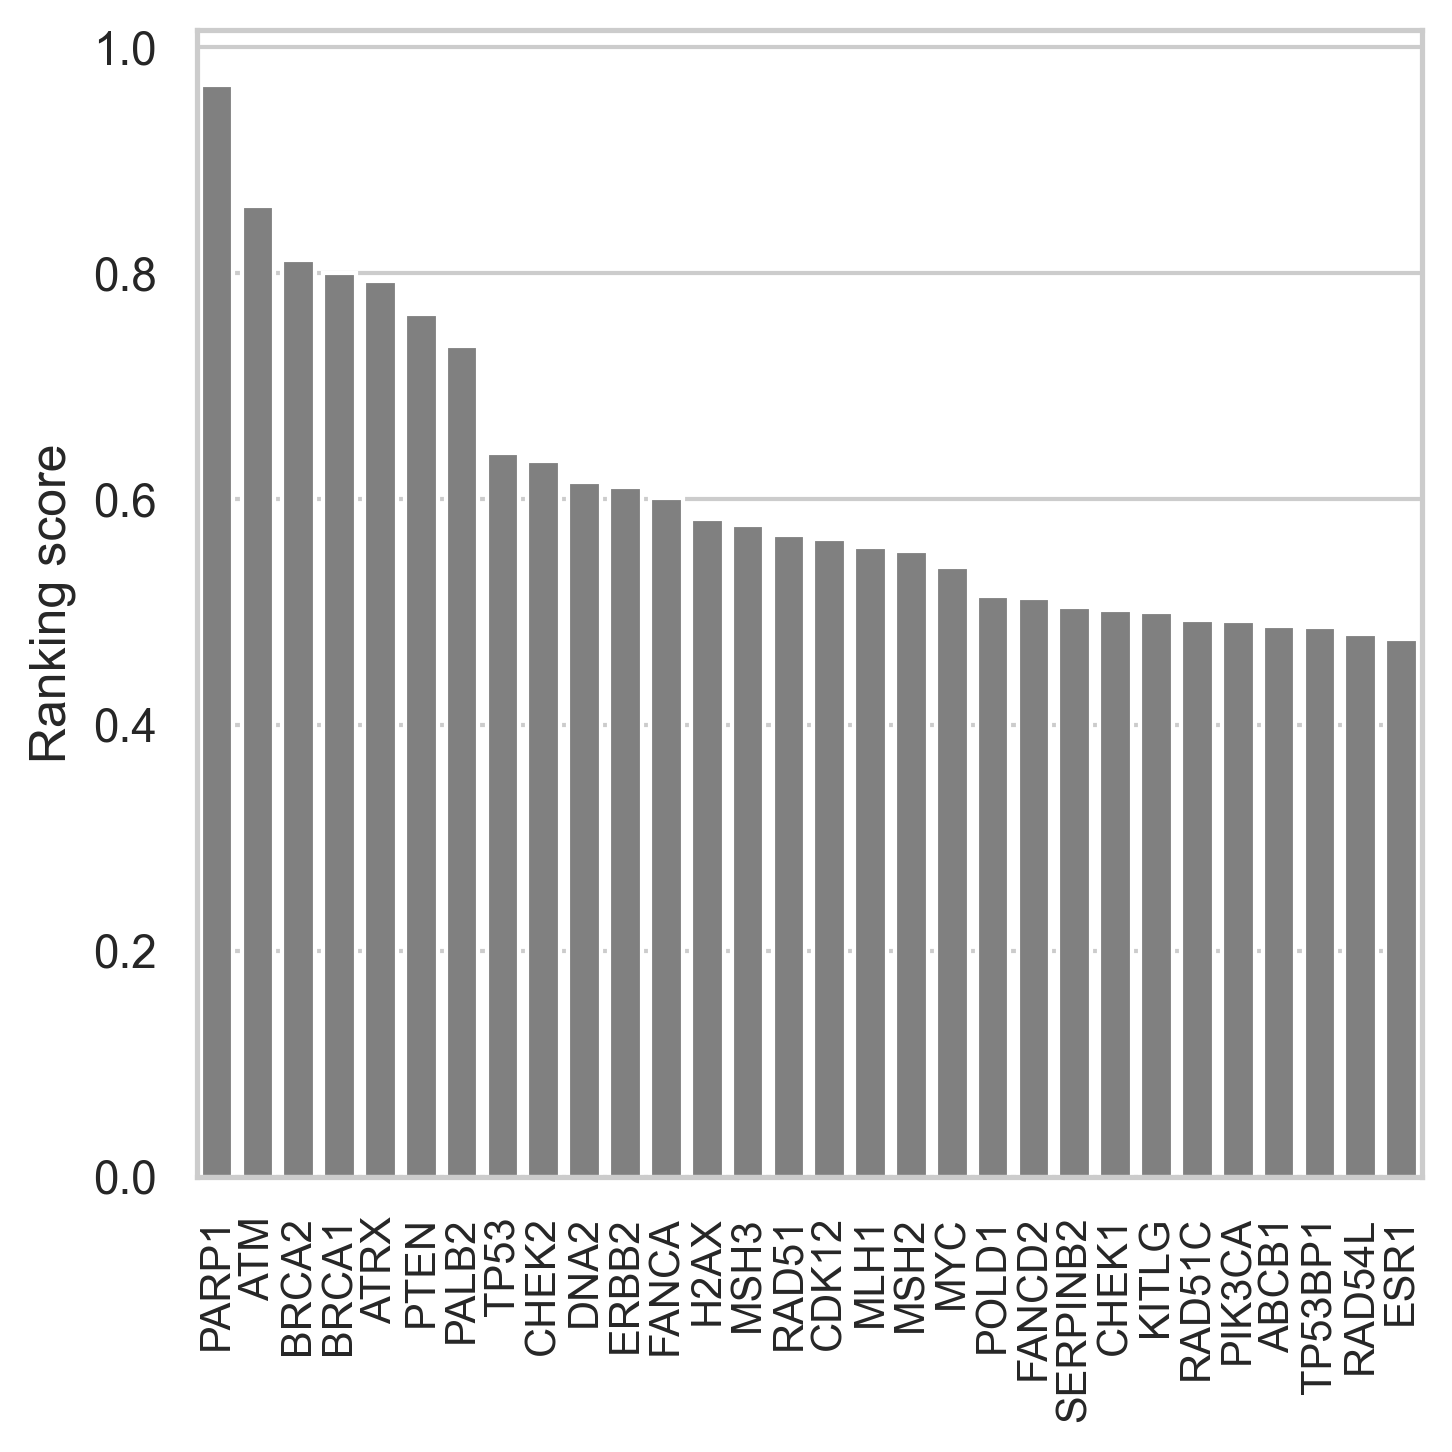

In [12]:
t2 = TCT.merge_by_ranking_index(result_ranked_by_primary_infores,
                           result_ranked_by_primary_infores2, 
                           top_n=30, fontsize=10, 
                           title_fontsize=12)

In [ ]:

TCT.visulize_path(input_node1_id, TCT.get_curie("ATM"), input_node3_id, result, result2)  #todo: collapse the resulst if the infores are the same

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'title': 'Path', 'nodeSpacing': 80, 'edgeLengthVal': 50}, cy…

,Subject,Object,Predicates,Subject_name,Object_name
0,NCBIGene:472,NCBIGene:675,coexpressed_with::infores:string,ATM,BRCA2
1,NCBIGene:675,NCBIGene:472,coexpressed_with::infores:string,BRCA2,ATM
2,NCBIGene:472,NCBIGene:675,physically_interacts_with::infores:string,ATM,BRCA2
3,NCBIGene:675,NCBIGene:472,physically_interacts_with::infores:string,BRCA2,ATM
4,NCBIGene:472,NCBIGene:675,genetically_interacts_with::infores:hetionet,ATM,BRCA2
5,NCBIGene:675,NCBIGene:472,physically_interacts_with::infores:biogrid,BRCA2,ATM
6,NCBIGene:675,NCBIGene:472,interacts_with::infores:biogrid,BRCA2,ATM
7,NCBIGene:675,NCBIGene:472,interacts_with::infores:string,BRCA2,ATM
8,NCBIGene:675,NCBIGene:472,coexists_with::infores:semmeddb,BRCA2,ATM
9,NCBIGene:675,NCBIGene:472,genetically_interacts_with::infores:hetionet,BRCA2,ATM
